In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:

from datetime import datetime
import requests
import json
from pyspark.ml.regression import DecisionTreeRegressor

In [10]:
import matplotlib as plt
import seaborn as sns

In [47]:
from google.cloud import bigquery
import os
import pandas as pd
# Create a BigQuery client object
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from google.cloud import bigquery
#import db-dtypes
import os
import pandas as pd
# Create a BigQuery client object
#from pyspark.sql import SparkSession
#from pyspark.ml.regression import LinearRegression
#from pyspark.ml.feature import VectorAssembler

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= "nifty-expanse-380117-34182b0834a5.json"
client = bigquery.Client()
# Construct the SQL query to fetch data from a table in the database
sql_query1 = """SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2020`"""
# Execute the query and fetch the results
query_job = client.query(sql_query1)
df1 = query_job.to_dataframe()


# Construct the SQL query to fetch data from a table in the database
sql_query2 = """SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2021`"""
# Execute the query and fetch the results
query_job = client.query(sql_query1)
df2 = query_job.to_dataframe()


# Construct the SQL query to fetch data from a table in the database
sql_query3 = """SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2022`"""
# Execute the query and fetch the results
query_job = client.query(sql_query1)
df3 = query_job.to_dataframe()





In [2]:
import pandas as pd
concatenated_df = pd.concat([df1, df2, df3], axis=0)

# Reset the index of the concatenated DataFrame
data = concatenated_df.reset_index(drop=True)

In [3]:
data.shape

(5202495, 24)

In [47]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
data['dropoff_hour'] = data['dropoff_datetime'].dt.hour

In [48]:
data = data.fillna(0)
new_data= data.apply(lambda x: pd.Categorical(x).codes if x.dtype == 'object' else x)
new_data=new_data.drop(['time_between_service','distance_between_service','vendor_id','pickup_datetime','dropoff_datetime'], axis=1)

In [40]:
X= new_data.drop('fare_amount',axis=1)
y=new_data['fare_amount']

In [49]:
new_data = new_data[new_data['passenger_count'] >= 1]
new_data = new_data[new_data['trip_distance'] >= 1]
new_data= new_data[new_data['fare_amount']>= 1]

In [42]:
new_data.to_csv("new_data.csv", index=False)

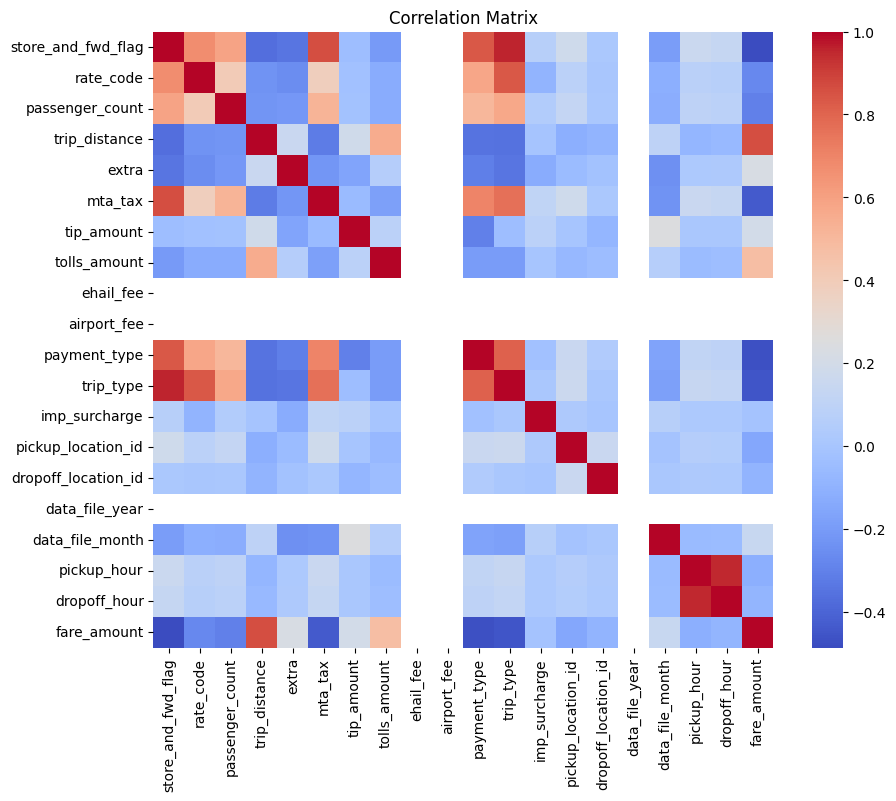

In [21]:
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(10,8))

# Create a correlation matrix
correlation_matrix = pd.concat([X, y], axis=1).corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')

# Save the figure as a PNG file
fig.savefig('heat.png')

In [29]:
new_data.columns

Index(['store_and_fwd_flag', 'rate_code', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'ehail_fee', 'airport_fee', 'payment_type', 'trip_type',
       'imp_surcharge', 'pickup_location_id', 'dropoff_location_id',
       'data_file_year', 'data_file_month', 'pickup_hour', 'dropoff_hour'],
      dtype='object')

In [12]:
spark = SparkSession.builder.appName("LinearRegression").getOrCreate()

In [29]:
sdf = spark.createDataFrame(new_data)

In [30]:
x1=new_data.drop(['fare_amount','total_amount'],axis=1).columns.tolist()
#x1=new_data[['data_file_month','data_file_year','tip_amount','extra','trip_distance']].columns.to_list()

In [31]:
assembler = VectorAssembler(inputCols=x1, outputCol="features")
sdf = assembler.transform(sdf).select("features", "fare_amount")

In [32]:
train_data, test_data = sdf.randomSplit([0.8, 0.2])


lr = LinearRegression(featuresCol="features", labelCol="fare_amount", maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train_data)


predictions = model.transform(test_data)

In [33]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) for Linear Regression = %g" % rmse)
print("R2 score (RMSE) for Linear Regression = %g" % r2)

Root Mean Squared Error (RMSE) for Linear Regression = 536.791
R2 score (RMSE) for Linear Regression = 0.721215


In [35]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol='fare_amount')
model2 = dt.fit(train_data)
predictions = model2.transform(test_data)


In [50]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) for DecisionTree Regression = %g" % rmse)
print("R2 score (RMSE) for DecisionTree Regression = %g" % r2)

Root Mean Squared Error (RMSE) for DecisionTree Regression = 463.983
R2 score (RMSE) for DecisionTree Regression = 0.791713


In [42]:
# Create a Ridge Regression model with a regularization parameter of 0.1
ridge = LinearRegression(regParam=0.1, elasticNetParam=0.0,labelCol="fare_amount", predictionCol="prediction",)
model3 = ridge.fit(train_data)
predictions = model3.transform(test_data)

In [51]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) for Ridge Regression = %g" % rmse)
print("R2 score (RMSE) for Ridge Regression Regression = %g" % r2)

Root Mean Squared Error (RMSE) for Ridge Regression = 463.983
R2 score (RMSE) for Ridge Regression Regression = 0.791713


In [45]:
# Train a linear regression model on the polynomial features
poly = LinearRegression(labelCol="fare_amount", predictionCol="prediction", maxIter=10, regParam=0.1, elasticNetParam=0.1)
model4 = poly.fit(train_data)
predictions = model4.transform(test_data)

In [52]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) for Polynomial Regression = %g" % rmse)
print("R2 score (RMSE) for Polynomial Regression = %g" % r2)

Root Mean Squared Error (RMSE) for Polynomial Regression = 463.983
R2 score (RMSE) for Polynomial Regression = 0.791713


In [48]:
rf = RandomForestRegressor(labelCol="fare_amount", predictionCol="prediction")
model5 = rf.fit(train_data)
predictions = model5.transform(test_data)

In [53]:
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) for RandomForest Regression = %g" % rmse)
print("R2 score (RMSE) for RandomForest Regression = %g" % r2)

Root Mean Squared Error (RMSE) for RandomForest Regression = 463.983
R2 score (RMSE) for RandomForest Regression = 0.791713
